In [2]:
import jax

import numpy as np
import matplotlib.pyplot as plt
import jax.numpy as jnp
from jax import random
from dataclasses import asdict
from sklearn.model_selection import train_test_split
from src.gaussian_measure import (
    NeuralNetworkGaussianMeasure,
    StochasticNeuralNetworkGaussianProcess,
)

from src._kernels.base_kernels import (
    NeuralNetworkGaussianProcessKernel,
    NeuralNetworkGaussianProcessKernelParameters,
)
from src.mean_functions import Constant, MultiLayerPerceptron

jax.config.update("jax_enable_x64", True)

In [3]:
import neural_tangents as nt
from neural_tangents import stax
from jax import jit

# Generate Random Data

In [4]:
SEED = 42
np.random.seed(SEED)
key = random.PRNGKey(SEED)
number_of_data_points = 1000
training_data_percentage = 0.9
number_of_training_data_points = jnp.ceil(
    training_data_percentage * number_of_data_points
)
sigma_true = 0.5

x = jnp.linspace(-2, 2, number_of_data_points, dtype=np.float32).reshape(-1)

key, subkey = random.split(key)


def calculate_y(x):
    return (
        2 * jnp.sin(x * (jnp.pi)) + sigma_true * random.normal(subkey, shape=x.shape)
    ).reshape(-1)

In [5]:
train_ranges = [(-2, -1), (0, 2)]
test_ranges = [(-1, 0)]
x_train = []
y_train = []
for train_range in train_ranges:
    x_train.extend(x[(train_range[0] <= x) & (x <= train_range[1])])

x_test = []
y_test = []
for test_range in test_ranges:
    x_test.extend(x[(test_range[0] <= x) & (x <= test_range[1])])
x = x.reshape(-1, 1)
x_train = jnp.array(x_train).reshape(-1, 1)
x_test = jnp.array(x_test).reshape(-1, 1)
y_train = calculate_y(x_train)
y_test = calculate_y(x_test)

In [6]:
number_of_inducing_points = int(2 * np.sqrt(number_of_data_points))

key, subkey = random.split(key)
inducing_indices = random.choice(
    key,
    a=jnp.arange(number_of_training_data_points).astype(int),
    shape=(number_of_inducing_points,),
    replace=False,
)
x_inducing, y_inducing = x_train[inducing_indices], y_train[inducing_indices]

# NNGP

In [7]:
init_fn, apply_fn, kernel_fn = stax.serial(
    # stax.Dense(10, W_std=5, b_std=5), stax.Erf(),
    stax.Dense(10, W_std=5, b_std=5),
    stax.Erf(),
    stax.Dense(1, W_std=10, b_std=200),
)

apply_fn = jit(apply_fn)
kernel_fn = jit(kernel_fn, static_argnames="get")

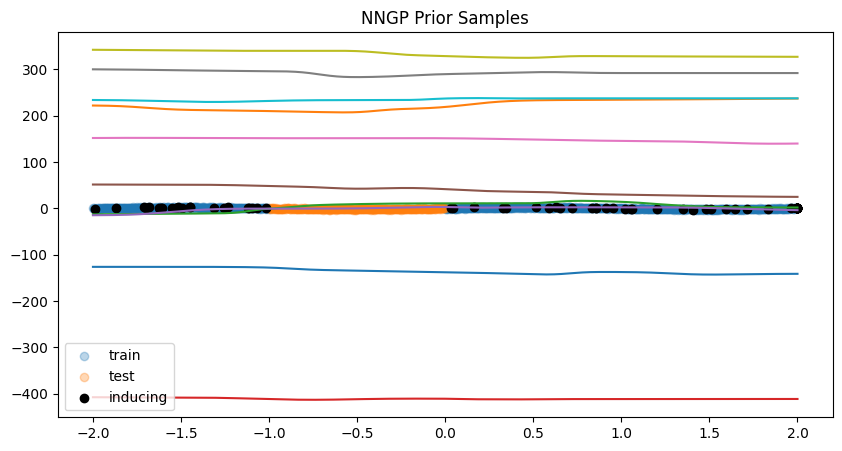

In [8]:
plt.figure(figsize=(10, 5))

prior_draws = []
for _ in range(10):
    key, net_key = random.split(key)
    _, params = init_fn(net_key, (-1, 1))
    prior_draws += [apply_fn(params, x)]
for p in prior_draws:
    plt.plot(x, p)
plt.title("NNGP Prior Samples")
plt.scatter(x_train, y_train, label="train", alpha=0.3)
plt.scatter(x_test, y_test, label="test", alpha=0.3)
plt.scatter(x_inducing, y_inducing, label="inducing", color="black")
plt.legend()
plt.show()

In [11]:
params

[(Array([[-1.78635378, -0.00256233,  0.62388706, -0.04035131, -0.58078736,
          -0.3303561 , -0.33683574,  0.55366914, -1.5473251 , -0.75048971]],      dtype=float64),
  Array([[-0.15506717,  1.09727072,  0.70793983,  1.06758497, -0.8957327 ,
           0.97517915, -2.42068187,  0.75771715,  0.44020708,  0.17360635]],      dtype=float64)),
 (),
 (Array([[-0.57746654],
         [-0.98204988],
         [ 1.16888838],
         [ 1.18893812],
         [ 0.96980854],
         [ 0.24154046],
         [ 1.11457216],
         [-0.26350376],
         [ 0.34335405],
         [-0.36947131]], dtype=float64),
  Array([[1.18931217]], dtype=float64))]

In [8]:
kernel = kernel_fn(x, x, "nngp")
stdev = np.sqrt(np.diag(kernel))
mean = np.zeros(x.shape[0])

In [9]:
neural_network_gaussian_process_kernel_parameters = (
    NeuralNetworkGaussianProcessKernelParameters(kernel_function=kernel_fn)
)
neural_network_gaussian_process_kernel = NeuralNetworkGaussianProcessKernel()

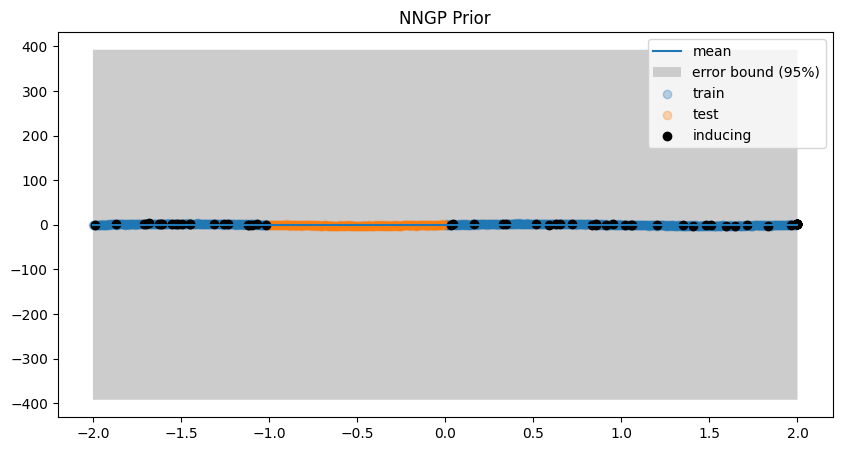

In [10]:
plt.figure(figsize=(10, 5))
plt.plot(x.reshape(-1), mean, label="mean")
plt.fill_between(
    x.reshape(-1),
    (mean - 1.96 * stdev).reshape(-1),
    (mean + 1.96 * stdev).reshape(-1),
    facecolor=(0.8, 0.8, 0.8),
    label="error bound (95%)",
)
plt.title("NNGP Prior")
plt.scatter(x_train, y_train, label="train", alpha=0.3)
plt.scatter(x_test, y_test, label="test", alpha=0.3)
plt.scatter(x_inducing, y_inducing, label="inducing", color="black")
plt.legend()
plt.show()

In [11]:
predict_fn = nt.predict.gradient_descent_mse_ensemble(
    kernel_fn, x_inducing, y_inducing.reshape(-1, 1), diag_reg=1e-4
)
neural_network_gaussian_measure_parameters = NeuralNetworkGaussianMeasure.Parameters(
    log_sigma=jnp.log(1.0),
    mean=None,
    kernel=neural_network_gaussian_process_kernel_parameters,
    predict_function=predict_fn,
)
neural_network_gaussian_measure = NeuralNetworkGaussianMeasure(
    kernel=neural_network_gaussian_process_kernel
)

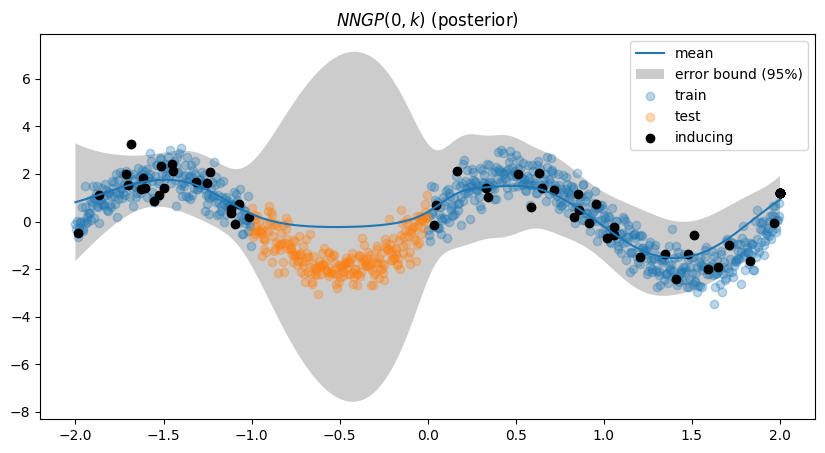

In [12]:
mean, covariance = neural_network_gaussian_measure.mean_and_covariance(
    x, **asdict(neural_network_gaussian_measure_parameters)
)
plt.figure(figsize=(10, 5))
plt.plot(x.reshape(-1), mean, label="mean")
stdev = np.sqrt(np.diag(covariance))
plt.fill_between(
    x.reshape(-1),
    (mean - 1.96 * stdev).reshape(-1),
    (mean + 1.96 * stdev).reshape(-1),
    facecolor=(0.8, 0.8, 0.8),
    label="error bound (95%)",
)
plt.title("$NNGP(0, k)$ (posterior)")
plt.scatter(x_train, y_train, label="train", alpha=0.3)
plt.scatter(x_test, y_test, label="test", alpha=0.3)
plt.scatter(x_inducing, y_inducing, label="inducing", color="black")
plt.legend()
plt.show()

# Variational GP

In [14]:
from src.kernels.variational_kernels import VariationalKernel

In [15]:
variational_kernel = VariationalKernel(
    base_kernel=neural_network_gaussian_process_kernel,
    inducing_points=x_inducing,
    regularisation=1e-7,
)
variational_kernel_parameters = VariationalKernel.Parameters(
    log_sigma=jnp.log(300),
    base_kernel_parameters=neural_network_gaussian_process_kernel_parameters,
)

In [16]:
gram = variational_kernel.kernel(variational_kernel_parameters, x)
jnp.diagonal(gram).mean()

Array(3.25375912e+17, dtype=float64)

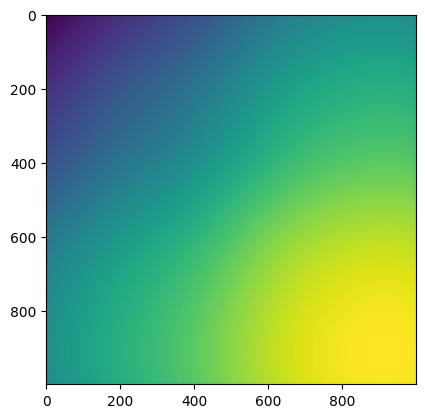

In [17]:
plt.imshow(gram)

In [18]:
neural_network = MultiLayerPerceptron([1, 20, 20, 1])
key, subkey = jax.random.split(key)
neural_network_parameters = neural_network.init(subkey, x_train)

In [19]:
svgp = StochasticNeuralNetworkGaussianProcess(
    x_train, y_train, variational_kernel, neural_network
)
key, subkey = jax.random.split(key)

svgp_parameters = StochasticNeuralNetworkGaussianProcess.Parameters(
    log_sigma=neural_network_gaussian_measure_parameters.log_sigma,
    kernel=variational_kernel_parameters,
    mean=neural_network_parameters,
    beta=0.1 * random.normal(subkey, shape=(number_of_inducing_points, 1)),
    predict_function=predict_fn,
    mean_shift=0,
)

In [20]:
y_initial_prediciton, _ = svgp.mean_and_covariance(
    x_inducing, **asdict(svgp_parameters)
)
y_inducing_error = y_inducing - y_initial_prediciton
mean_y_inducing_error = np.mean(y_inducing_error)
y_inducing_error = y_inducing_error - mean_y_inducing_error

In [21]:
# Same as JAX version but using model.apply().
@jax.jit
def mse(params, x_batched, y_batched):
    # Define the squared loss for a single pair (x,y)
    def squared_error(x, y):
        pred = neural_network.apply(params, x)
        return jnp.inner(y - pred, y - pred) / 2.0

    # Vectorize the previous to compute the average of the loss on all samples.
    return jnp.mean(jax.vmap(squared_error)(x_batched, y_batched), axis=0)


loss_grad_fn = jax.value_and_grad(mse)

In [22]:
learning_rate = 1e-3  # Gradient step size.


@jax.jit
def update_params(params, learning_rate, grads):
    params = jax.tree_util.tree_map(lambda p, g: p - learning_rate * g, params, grads)
    return params


for i in range(200001):
    # Perform one gradient update.
    loss_val, grads = loss_grad_fn(
        neural_network_parameters, x_inducing, y_inducing_error
    )
    neural_network_parameters = update_params(
        neural_network_parameters, learning_rate, grads
    )
    if i % 10000 == 0:
        print(f"Loss step {i}: ", loss_val)

Loss step 0:  1124.930374902621
Loss step 10000:  0.7439793716475046
Loss step 20000:  0.2872273305185401
Loss step 30000:  0.22180299058204903
Loss step 40000:  0.19316837862853933
Loss step 50000:  0.17859412631870686
Loss step 60000:  0.16898664687475318
Loss step 70000:  0.1620156013832094
Loss step 80000:  0.1566140792335434
Loss step 90000:  0.1523662854102632
Loss step 100000:  0.1489484562849454
Loss step 110000:  0.1461493662235321
Loss step 120000:  0.14375806932894544
Loss step 130000:  0.1416891837727148
Loss step 140000:  0.13982779824549968
Loss step 150000:  0.13817895258465054
Loss step 160000:  0.13669349476985374
Loss step 170000:  0.13538997018181528
Loss step 180000:  0.1341711294173371
Loss step 190000:  0.13308209431464416
Loss step 200000:  0.13213792867757995


In [23]:
svgp_parameters.mean = neural_network_parameters
svgp_parameters.mean_shift = mean_y_inducing_error

In [25]:
from src.dissimilarity_metrics import (
    GaussianWassersteinDistance,
    GaussianWassersteinDistanceFrozenParameters,
    GaussianWassersteinDistanceVariableParameters,
)

In [26]:
gaussian_wasserstein_distance_frozen_parameters = GaussianWassersteinDistanceFrozenParameters(
    gaussian_measure_p_mean=neural_network_gaussian_measure_parameters.mean,
    gaussian_measure_p_kernel=neural_network_gaussian_measure_parameters.kernel,
    gaussian_measure_p_log_sigma=neural_network_gaussian_measure_parameters.log_sigma,
    gaussian_measure_q_kernel=svgp_parameters.kernel,
    gaussian_measure_q_mean_shift=svgp_parameters.mean_shift,
)
gaussian_wasserstein_distance_variable_parameters = (
    GaussianWassersteinDistanceVariableParameters(
        gaussian_measure_q_mean=svgp_parameters.mean,
        gaussian_measure_q_beta=svgp_parameters.beta,
    )
)
gaussian_wasserstein_distance = GaussianWassersteinDistance(
    gaussian_measure_p=neural_network_gaussian_measure,
    gaussian_measure_q=svgp,
)

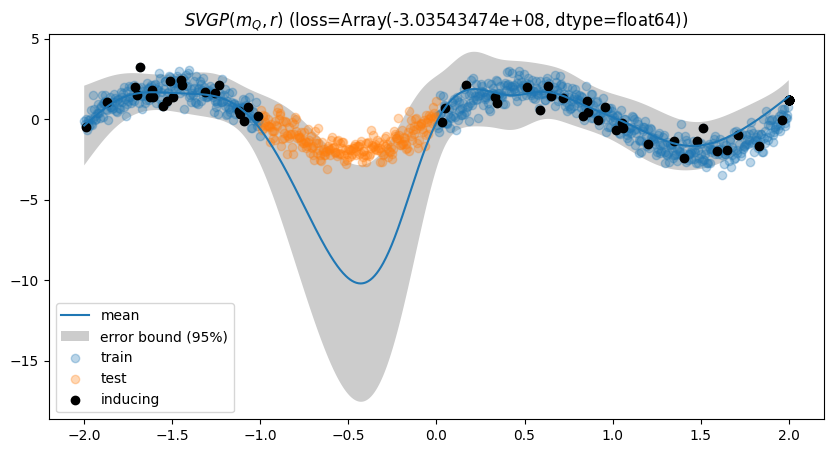

In [27]:
parameter_args = asdict(gaussian_wasserstein_distance_variable_parameters)
mean, covariance = svgp.mean_and_covariance(x, **asdict(svgp_parameters))
loss = gaussian_wasserstein_distance.calculate(
    x_train,
    y_train,
    x_train,
    x_train.shape[0],
    asdict(gaussian_wasserstein_distance_frozen_parameters),
    parameter_args,
    predict_function=predict_fn,
)
plt.figure(figsize=(10, 5))
plt.plot(x.reshape(-1), mean, label="mean")
stdev = np.sqrt(np.diag(covariance))
plt.fill_between(
    x.reshape(-1),
    (mean - 1.96 * stdev).reshape(-1),
    (mean + 1.96 * stdev).reshape(-1),
    facecolor=(0.8, 0.8, 0.8),
    label="error bound (95%)",
)
plt.title(f"$SVGP(m_Q, r)$ ({loss=})")
plt.scatter(x_train, y_train, label="train", alpha=0.3)
plt.scatter(x_test, y_test, label="test", alpha=0.3)
plt.scatter(x_inducing, y_inducing, label="inducing", color="black")
plt.legend()
plt.show()

# GWI

In [28]:
from src.dissimilarity_metrics import (
    GaussianWassersteinDistance,
    GaussianWassersteinDistanceFrozenParameters,
    GaussianWassersteinDistanceVariableParameters,
)

In [29]:
gaussian_wasserstein_distance_frozen_parameters = GaussianWassersteinDistanceFrozenParameters(
    gaussian_measure_p_mean=neural_network_gaussian_measure_parameters.mean,
    gaussian_measure_p_kernel=neural_network_gaussian_measure_parameters.kernel,
    gaussian_measure_p_log_sigma=neural_network_gaussian_measure_parameters.log_sigma,
    gaussian_measure_q_kernel=svgp_parameters.kernel,
    gaussian_measure_q_mean_shift=svgp_parameters.mean_shift,
)
gaussian_wasserstein_distance_variable_parameters = (
    GaussianWassersteinDistanceVariableParameters(
        gaussian_measure_q_mean=svgp_parameters.mean,
        gaussian_measure_q_beta=svgp_parameters.beta,
    )
)
gaussian_wasserstein_distance = GaussianWassersteinDistance(
    gaussian_measure_p=neural_network_gaussian_measure,
    gaussian_measure_q=svgp,
)

In [30]:
import optax

learning_rate = 1e-9
optimizer = optax.adam(learning_rate)
number_of_iterations = 201

In [31]:
parameter_args = asdict(gaussian_wasserstein_distance_variable_parameters)

gaussian_wasserstein_distance.calculate(
    x_train,
    y_train,
    x_train,
    x_train.shape[0],
    asdict(gaussian_wasserstein_distance_frozen_parameters),
    parameter_args,
    predict_function=predict_fn,
)

Array(-3.03543474e+08, dtype=float64)

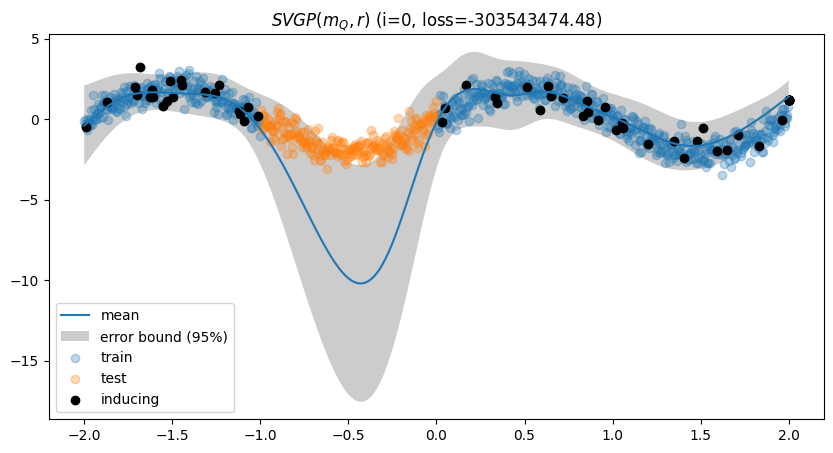

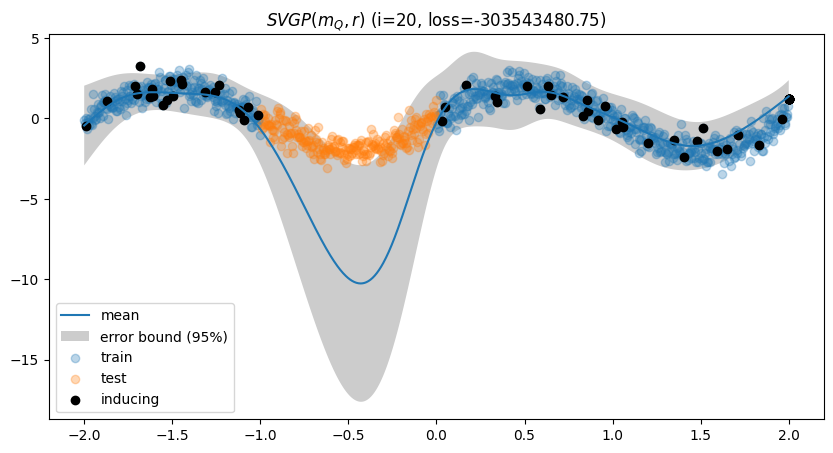

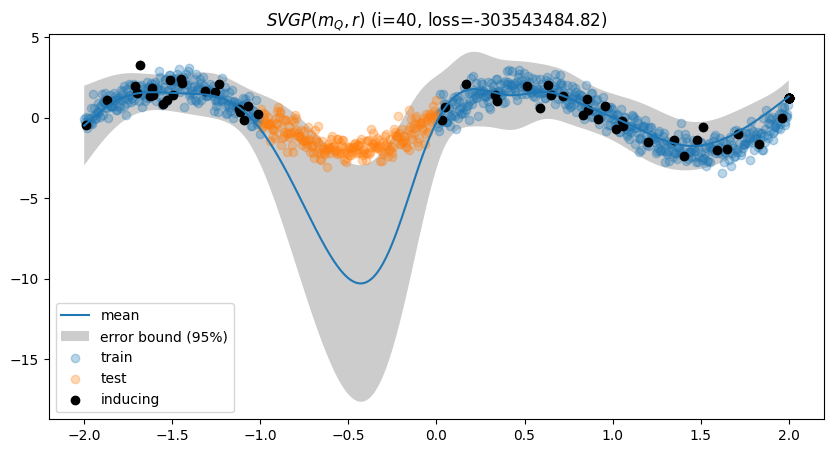

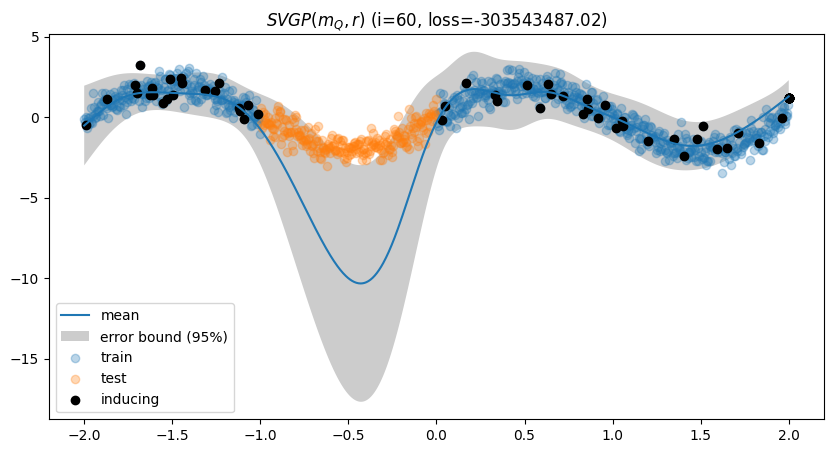

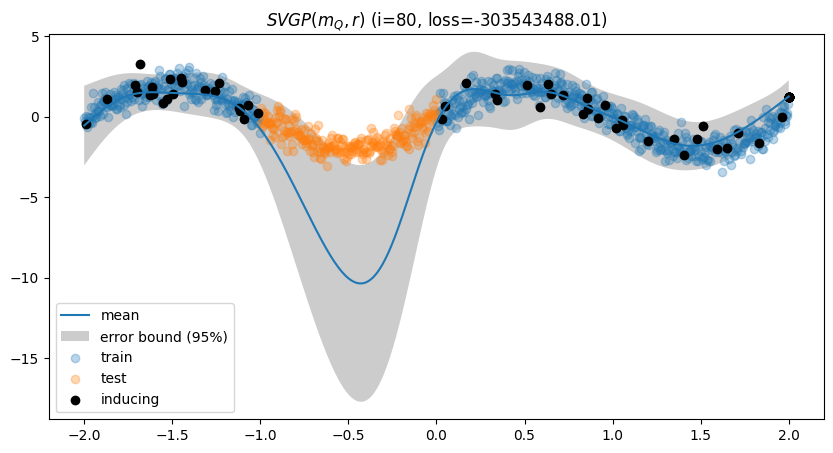

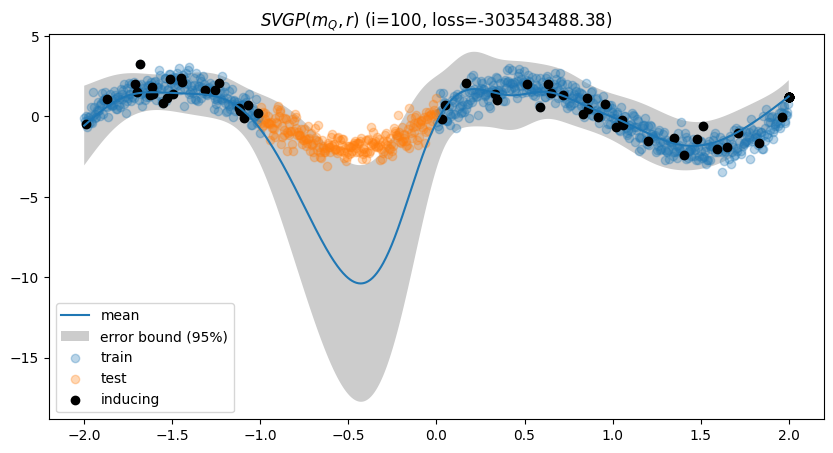

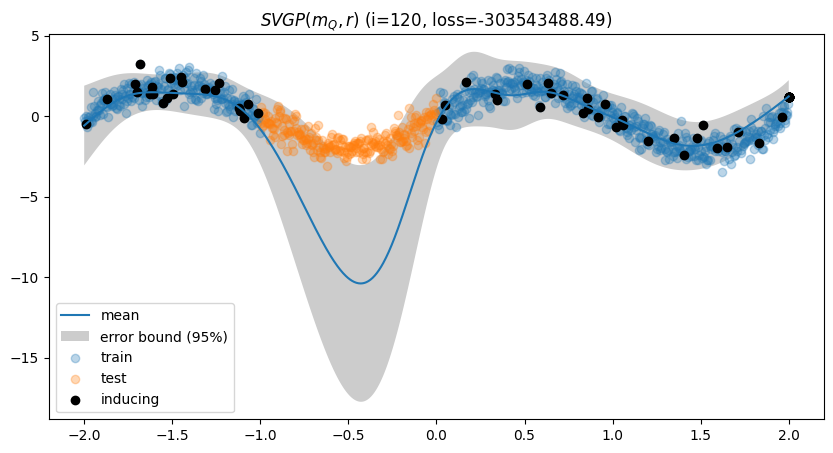

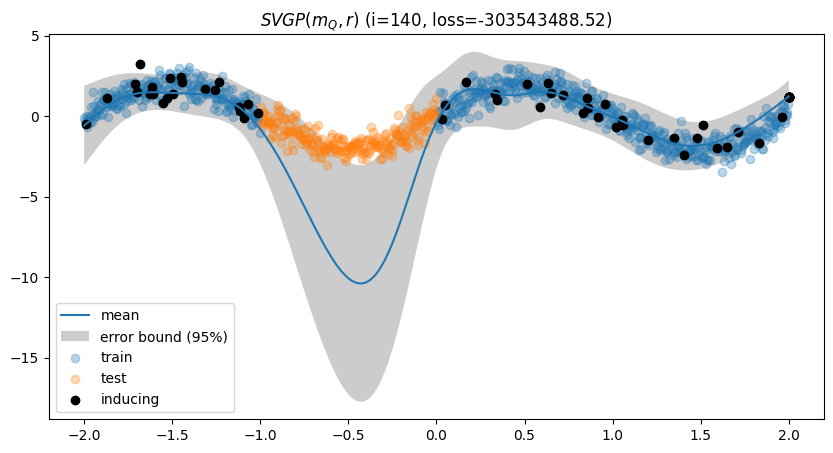

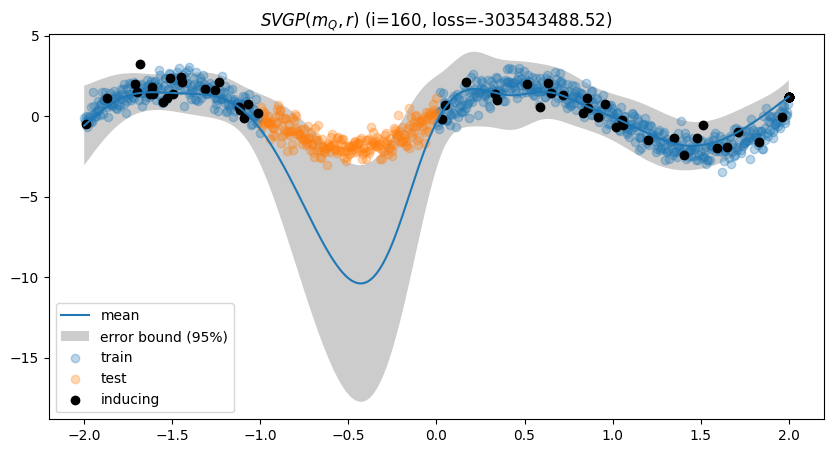

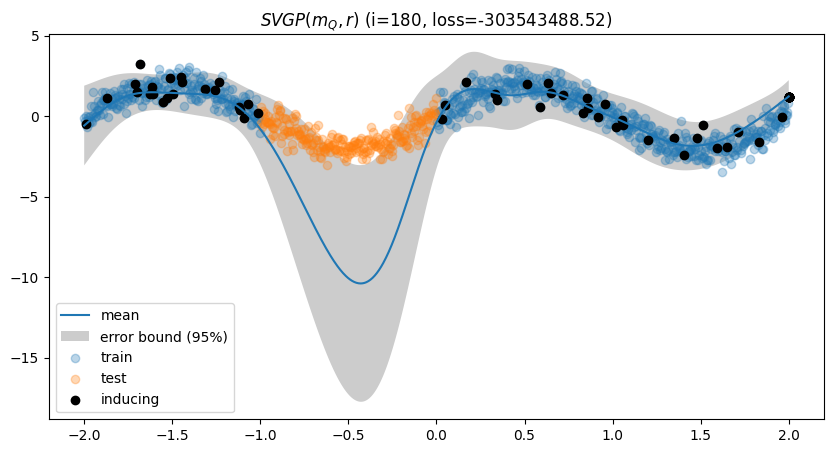

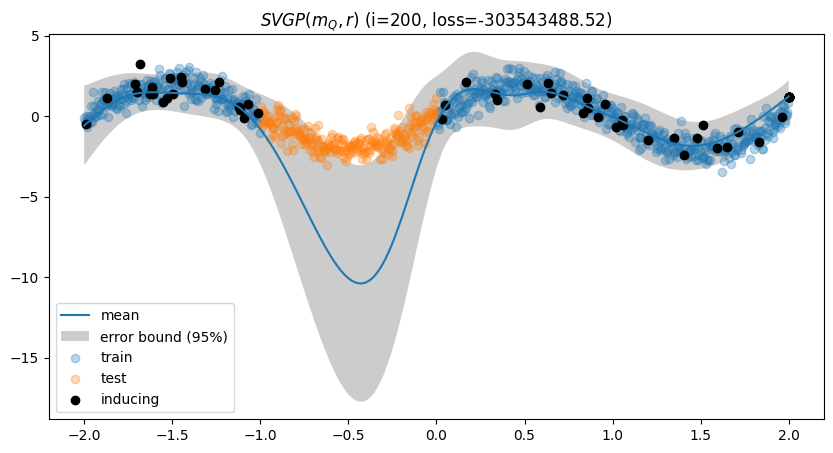

In [32]:
parameter_args = asdict(gaussian_wasserstein_distance_variable_parameters)

losses = []
opt_state = optimizer.init(parameter_args)
for i in range(number_of_iterations):
    losses.append(
        gaussian_wasserstein_distance.calculate(
            x_train,
            y_train,
            x_train,
            x_train.shape[0],
            asdict(gaussian_wasserstein_distance_frozen_parameters),
            parameter_args,
            predict_function=predict_fn,
        ).item()
    )
    if i % 20 == 0:
        trained_variational_kernel_parameters = (
            GaussianWassersteinDistanceVariableParameters(**parameter_args)
        )
        loss = np.round(
            gaussian_wasserstein_distance.calculate(
                x_train,
                y_train,
                x_train,
                x_train.shape[0],
                asdict(gaussian_wasserstein_distance_frozen_parameters),
                parameter_args,
                predict_function=predict_fn,
            ).item(),
            2,
        )
        trained_svgp_parameters = svgp.Parameters(
            log_sigma=gaussian_wasserstein_distance_frozen_parameters.gaussian_measure_p_log_sigma,
            kernel=gaussian_wasserstein_distance_frozen_parameters.gaussian_measure_q_kernel,
            mean=trained_variational_kernel_parameters.gaussian_measure_q_mean,
            beta=trained_variational_kernel_parameters.gaussian_measure_q_beta,
            mean_shift=gaussian_wasserstein_distance_frozen_parameters.gaussian_measure_q_mean_shift,
            predict_function=predict_fn,
        )
        mean, covariance = svgp.mean_and_covariance(
            x, **asdict(trained_svgp_parameters)
        )
        plt.figure(figsize=(10, 5))
        plt.plot(x.reshape(-1), mean, label="mean")
        stdev = np.sqrt(np.diag(covariance))
        plt.fill_between(
            x.reshape(-1),
            (mean - 1.96 * stdev).reshape(-1),
            (mean + 1.96 * stdev).reshape(-1),
            facecolor=(0.8, 0.8, 0.8),
            label="error bound (95%)",
        )
        plt.title(f"$SVGP(m_Q, r)$ ({i=}, {loss=})")
        plt.scatter(x_train, y_train, label="train", alpha=0.3)
        plt.scatter(x_test, y_test, label="test", alpha=0.3)
        plt.scatter(x_inducing, y_inducing, label="inducing", color="black")
        plt.legend()
        plt.show()

    gradients = jax.grad(
        lambda parameter_args: gaussian_wasserstein_distance.calculate(
            x_train,
            y_train,
            x_train,
            x_train.shape[0],
            asdict(gaussian_wasserstein_distance_frozen_parameters),
            parameter_args,
            predict_function=predict_fn,
        )
    )(parameter_args)
    updates, opt_state = optimizer.update(gradients, opt_state)
    parameter_args = optax.apply_updates(parameter_args, updates)

# Results

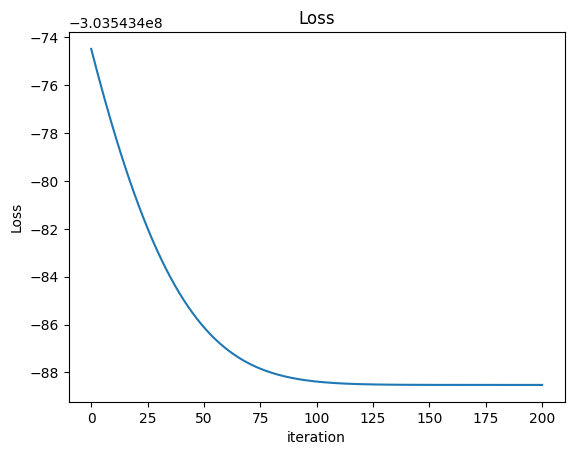

In [33]:
plt.title("Loss")
plt.xlabel("iteration")
plt.ylabel("Loss")
plt.plot(losses)

In [34]:
trained_variational_kernel_parameters = GaussianWassersteinDistanceVariableParameters(
    **parameter_args
)
trained_svgp_parameters = svgp.Parameters(
    log_sigma=gaussian_wasserstein_distance_frozen_parameters.gaussian_measure_p_log_sigma,
    kernel=gaussian_wasserstein_distance_frozen_parameters.gaussian_measure_q_kernel,
    mean=trained_variational_kernel_parameters.gaussian_measure_q_mean,
    beta=trained_variational_kernel_parameters.gaussian_measure_q_beta,
    predict_function=predict_fn,
    mean_shift=gaussian_wasserstein_distance_frozen_parameters.gaussian_measure_q_mean_shift,
)

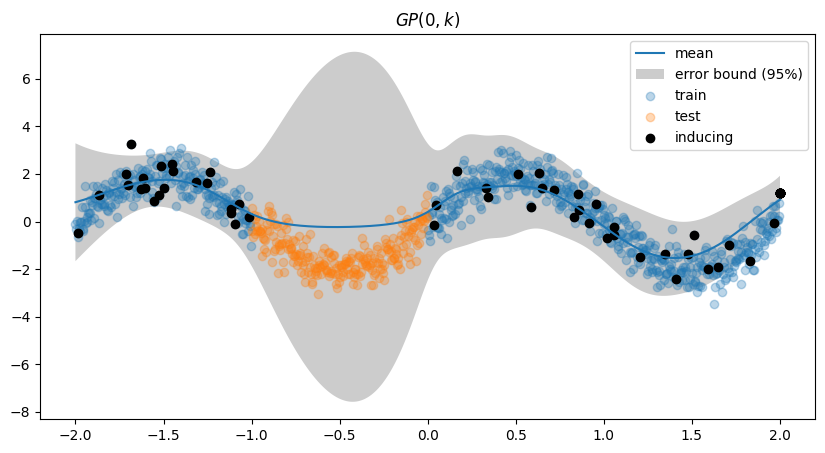

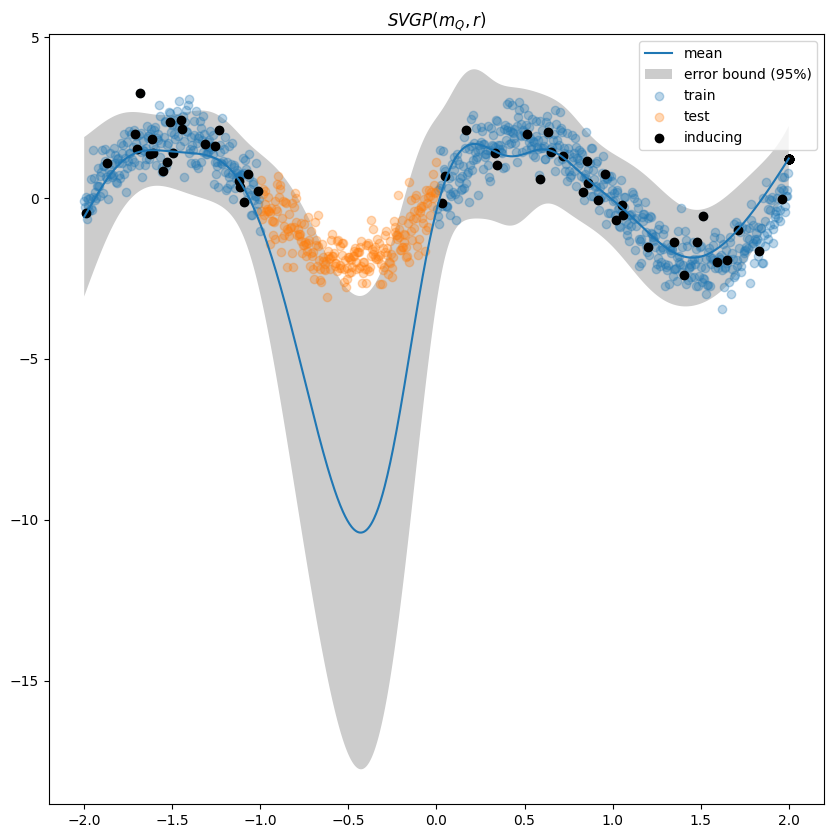

In [35]:
mean, covariance = neural_network_gaussian_measure.mean_and_covariance(
    x, **asdict(neural_network_gaussian_measure_parameters)
)
plt.figure(figsize=(10, 5))
plt.plot(x.reshape(-1), mean, label="mean")
stdev = np.sqrt(np.diag(covariance))
plt.fill_between(
    x.reshape(-1),
    (mean - 1.96 * stdev).reshape(-1),
    (mean + 1.96 * stdev).reshape(-1),
    facecolor=(0.8, 0.8, 0.8),
    label="error bound (95%)",
)
plt.title("$GP(0, k)$")
plt.scatter(x_train, y_train, label="train", alpha=0.3)
plt.scatter(x_test, y_test, label="test", alpha=0.3)
plt.scatter(x_inducing, y_inducing, label="inducing", color="black")
plt.legend()
plt.show()

mean, covariance = svgp.mean_and_covariance(x, **asdict(trained_svgp_parameters))
plt.figure(figsize=(10, 10))
plt.plot(x.reshape(-1), mean, label="mean")
stdev = np.sqrt(np.diag(covariance))
plt.fill_between(
    x.reshape(-1),
    (mean - 1.96 * stdev).reshape(-1),
    (mean + 1.96 * stdev).reshape(-1),
    facecolor=(0.8, 0.8, 0.8),
    label="error bound (95%)",
)
plt.title("$SVGP(m_Q, r)$")
plt.scatter(x_train, y_train, label="train", alpha=0.3)
plt.scatter(x_test, y_test, label="test", alpha=0.3)
plt.scatter(x_inducing, y_inducing, label="inducing", color="black")
plt.legend()
plt.show()